<a href="https://colab.research.google.com/github/29121999/project/blob/main/Balaram_Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from shutil import copyfile
from PIL import Image, UnidentifiedImageError
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Pneumonia Data Pre-processing

In [ ]:

# Function to categorize images based on their labels
def categorize_images(directory):
    virus_folder = os.path.join(directory, 'Vir')
    bacteria_folder = os.path.join(directory, 'Bac')

    os.makedirs(virus_folder, exist_ok=True)
    os.makedirs(bacteria_folder, exist_ok=True)

    for file in os.listdir(directory):
        if file.lower().endswith('.jpeg'):
            img_path = os.path.join(directory, file)
            try:
                with Image.open(img_path) as img:
                    if 'bacteria' in file.lower():
                        move(img_path, os.path.join(bacteria_folder, file))
                    elif 'virus' in file.lower():
                        move(img_path, os.path.join(virus_folder, file))
                    else:
                        print(f"not found")
            except UnidentifiedImageError:
                print(f"diff img format")

train_directory = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA'
test_directory = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'

# Categorize train and test images
categorize_images(train_directory)
categorize_images(test_directory)


In [ ]:
train_bacteria_dir = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA'
train_normal_dir = '/content/drive/MyDrive/chest_xray/train/NORMAL'
train_virus_dir = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS'

test_bacteria_dir = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/BACTERIA'
test_normal_dir = '/content/drive/MyDrive/chest_xray/test/NORMAL'
test_virus_dir = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS'

# Function to load images from a specified directory
def load_images(directory):
    loaded_images = []
    for file in os.listdir(directory):
        if file.endswith('.jpeg'):
            img_path = os.path.join(directory, file)
            img = Image.open(img_path)
            loaded_images.append(img)
    return loaded_images

# Load training images
train_bacteria_images = load_images(train_bacteria_dir)
train_normal_images = load_images(train_normal_dir)
train_virus_images = load_images(train_virus_dir)

# Load test images
test_bacteria_images = load_images(test_bacteria_dir)
test_normal_images = load_images(test_normal_dir)
test_virus_images = load_images(test_virus_dir)

# Print dataset statistics
print("Training data counts - Bacteria:", len(train_bacteria_images),
      "Normal:", len(train_normal_images),
      "Virus:", len(train_virus_images))

print("Testing data counts - Bacteria:", len(test_bacteria_images),
      "Normal:", len(test_normal_images),
      "Virus:", len(test_virus_images))


In [ ]:
train_bacteria_resized = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA_normalized'
train_virus_resized = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS_normalized'
train_normal_resized = '/content/drive/MyDrive/chest_xray/train/NORMAL_normalized'

test_bacteria_resized = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/BACTERIA_normalized'
test_virus_resized = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS_normalized'
test_normal_resized = '/content/drive/MyDrive/chest_xray/test/NORMAL_normalized'

# Function to preprocess images: resizing and normalization
def preprocess_images(directory, target_size=(224, 224), output_dir=None):
    if output_dir is None:
        output_dir = directory
    else:
        os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    resized_count = 0
    already_resized_count = 0

    for file in os.listdir(directory):
        if file.endswith('.jpeg'):
            input_path = os.path.join(directory, file)
            output_path = os.path.join(output_dir, file)

            with Image.open(input_path) as img:
                # Resize the image if it doesn't match the target size
                if img.size != target_size:
                    resized_img = img.resize(target_size)
                    resized_img.save(output_path)
                    resized_count += 1

                    normalized_img = np.array(resized_img) / 255.0
                    normalized_img = Image.fromarray((normalized_img * 255).astype(np.uint8))
                    normalized_img.save(output_path)
                else:
                    already_resized_count += 1
                    normalized_img = np.array(img) / 255.0
                    normalized_img = Image.fromarray((normalized_img * 255).astype(np.uint8))
                    normalized_img.save(output_path)

    print("Number of images resized:", resized_count)
    print("Number of images already resized:", already_resized_count)

# Target size for resizing
image_size = (224, 224)

# Process training images
preprocess_images(bacteria_dir, image_size, train_bacteria_resized)
preprocess_images(virus_dir, image_size, train_virus_resized)
preprocess_images(normal_dir, image_size, train_normal_resized)

# Process testing images
preprocess_images(test_bacteria_dir, image_size, test_bacteria_resized)
preprocess_images(test_virus_dir, image_size, test_virus_resized)
preprocess_images(test_normal_dir, image_size, test_normal_resized)

Number of images resized: 2538
Number of images already resized: 0
Number of images resized: 1345
Number of images already resized: 0
Number of images resized: 0
Number of images already resized: 1349
Number of images resized: 242
Number of images already resized: 0
Number of images resized: 148
Number of images already resized: 0
Number of images resized: 234
Number of images already resized: 0


# pneumonia with **scratch**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

cnn_model = Sequential()

cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
cnn_model.add(Dropout(rate=0.1))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
cnn_model.add(Dropout(rate=0.2))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

cnn_model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
cnn_model.add(Dropout(rate=0.2))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(rate=0.2))

cnn_model.add(Dense(units=3, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_generator = train_data_gen.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical',
    subset='training'
)

val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_data_generator = val_data_gen.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical',
    subset='validation'
)

lr_adjuster = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

cnn_model.fit(
    train_data_generator,
    epochs=50,
    validation_data=validation_data_generator,
    callbacks=[lr_adjuster, early_stop]
)

# Save the trained model
cnn_model.save('/content/drive/MyDrive/chest_xray/model_custom.h5')


In [ ]:
test_data_generator = ImageDataGenerator(rescale=1./255)

test_data_flow = test_data_generator.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate(test_data_flow)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Found 624 images belonging to 3 classes.
20/20 [==============================] - 126s 6s/step - loss: 0.7335 - accuracy: 0.7019
Test Loss: 0.7334838509559631
Test Accuracy: 0.7019230723381042


In [ ]:
test_dirs = ['/content/drive/MyDrive/chest_xray/test/NORMAL_normalized',
             '/content/drive/MyDrive/chest_xray/test/BACTERIA_normalized',
             '/content/drive/MyDrive/chest_xray/test/VIRUS_normalized']

X_test_images = []
true_labels = []

for label, directory in enumerate(test_dirs):
    for file_name in os.listdir(directory):
        image_path = os.path.join(directory, file_name)
        image = load_img(image_path, target_size=(224, 224))
        image_array = img_to_array(image) / 255.0
        X_test_images.append(image_array)
        true_labels.append(label)

X_test_images = np.array(X_test_images)
true_labels = np.array(true_labels)

model = load_model('/content/drive/MyDrive/chest_xray/model_custom.h5')

predicted_probs = model.predict(X_test_images)
predicted_classes = np.argmax(predicted_probs, axis=1)

accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

20/20 [==============================] - 6s 59ms/step
Accuracy: 0.6153846153846154
Precision: 0.7468751599157929
Recall: 0.6153846153846154
F1 Score: 0.6060569568371146


#vgg model

In [ ]:
#vgg model with imagenet weights


from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_base.layers[:-10]:
    layer.trainable = False

transfer_model = models.Sequential()
transfer_model.add(vgg_base)
transfer_model.add(layers.GlobalAveragePooling2D())
transfer_model.add(layers.Dense(256, activation='relu'))
transfer_model.add(layers.Dropout(0.4))
transfer_model.add(layers.Dense(3, activation='softmax'))

transfer_model.compile(optimizer=Adam(learning_rate=0.00003),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_aug.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical'
)

validation_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_data = validation_aug.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical',
    subset='validation'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = transfer_model.fit(train_data,
                             epochs=40,
                             validation_data=val_data,
                             callbacks=[early_stopping])


model.save('/content/drive/MyDrive/chest_xray/vggmodel.h5')

58889256/58889256 [==============================] - 3s 0us/step
Found 5233 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.
Epoch 1/50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


163/164 [============================>.] - ETA: 5s - loss: 0.7503 - accuracy: 0.6662 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


164/164 [==============================] - 1005s 6s/step - loss: 0.7494 - accuracy: 0.6662 - val_loss: 0.6749 - val_accuracy: 0.7158
Epoch 2/50
164/164 [==============================] - 113s 675ms/step - loss: 0.5902 - accuracy: 0.7416 - val_loss: 0.5509 - val_accuracy: 0.7560
Epoch 3/50
164/164 [==============================] - 116s 685ms/step - loss: 0.5392 - accuracy: 0.7672 - val_loss: 0.6523 - val_accuracy: 0.7483
Epoch 4/50
164/164 [==============================] - 114s 680ms/step - loss: 0.5333 - accuracy: 0.7768 - val_loss: 0.4642 - val_accuracy: 0.7943
Epoch 5/50
164/164 [==============================] - 118s 704ms/step - loss: 0.5126 - accuracy: 0.7843 - val_loss: 0.4493 - val_accuracy: 0.8124
Epoch 6/50
164/164 [==============================] - 112s 671ms/step - loss: 0.4829 - accuracy: 0.7898 - val_loss: 0.9839 - val_accuracy: 0.6928
Epoch 7/50
164/164 [==============================] - 115s 686ms/step - loss: 0.4704 - accuracy: 0.7976 - val_loss: 0.4392 - val_accuracy

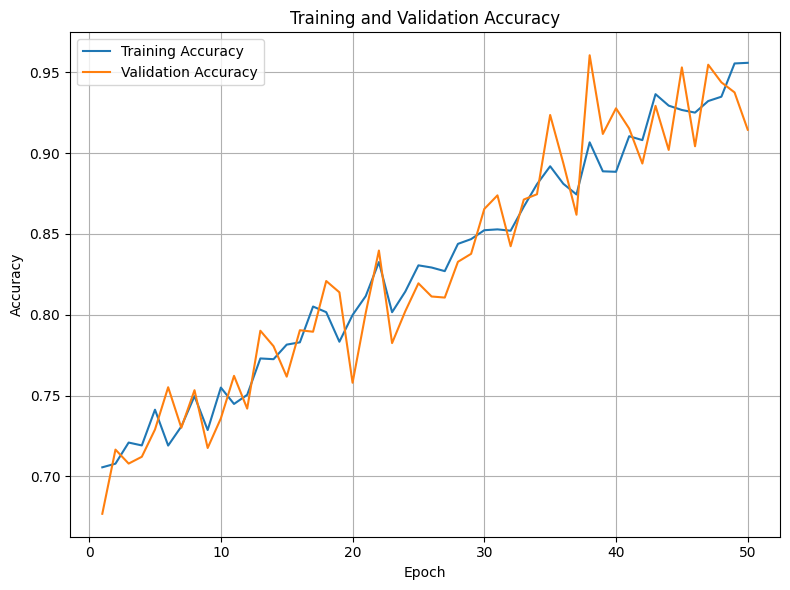

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_data_generator = ImageDataGenerator(rescale=1.0 / 255)

#test data loader
test_data_loader = test_data_generator.flow_from_directory(
    directory='/content/drive/MyDrive/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical',
    shuffle=False
)

loss_on_test, accuracy_on_test = model.evaluate(test_data_loader)

# Print the evaluation results
print("Test Loss:", loss_on_test)
print("Test Accuracy:", accuracy_on_test)

Found 624 images belonging to 3 classes.
20/20 [==============================] - 3s 126ms/step - loss: 0.4495 - accuracy: 0.8670
Test Loss: 0.449490487575531
Test Accuracy: 0.8669871687889099


In [ ]:
test_folders = [
    '/content/drive/MyDrive/chest_xray/test/NORMAL_normalized',
    '/content/drive/MyDrive/chest_xray/test/BACTERIA_normalized',
    '/content/drive/MyDrive/chest_xray/test/VIRUS_normalized'
]

X_test = []
y_actual = []

for class_label, folder in enumerate(test_folders):
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        image = load_img(file_path, target_size=(224, 224))
        image_array = img_to_array(image) / 255.0
        X_test.append(image_array)
        y_actual.append(class_label)

X_test = np.array(X_test)
y_actual = np.array(y_actual)

predicted_probs = model.predict(X_test)
predicted_classes = np.argmax(predicted_probs, axis=1)

accuracy = accuracy_score(y_actual, predicted_classes)
precision = precision_score(y_actual, predicted_classes, average='weighted')
recall = recall_score(y_actual, predicted_classes, average='weighted')
f1 = f1_score(y_actual, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


20/20 [==============================] - 12s 297ms/step
Accuracy: 0.8669871794871795
Precision: 0.8830238219963485
Recall: 0.8669871794871795
F1 Score: 0.8707261565547569


#Pneumonia with Chexnet

In [ ]:
# Load the DenseNet121 base model with pre-trained ImageNet weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last 20 for fine-tuning
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add custom layers for the new classification task
features = base_model.output
features = GlobalAveragePooling2D()(features)
features = Dense(256, activation='relu')(features)
features = Dropout(0.7)(features)
output_layer = Dense(3, activation='softmax')(features)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with a low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define data generators for training and validation datasets
train_data_generator = ImageDataGenerator(rescale=1.0 / 255)

train_loader = train_data_generator.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical',
    subset='training'
)

validation_data_generator = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

validation_loader = validation_data_generator.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical',
    subset='validation'
)

# Define early stopping callback to monitor validation accuracy
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with the training and validation datasets
history = model.fit(
    train_loader,
    epochs=50,
    validation_data=validation_loader,
    callbacks=[early_stop],
    workers=4,
    use_multiprocessing=True,
    max_queue_size=10
)


In [ ]:
model.save('/content/drive/MyDrive/chest_xray/chexNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


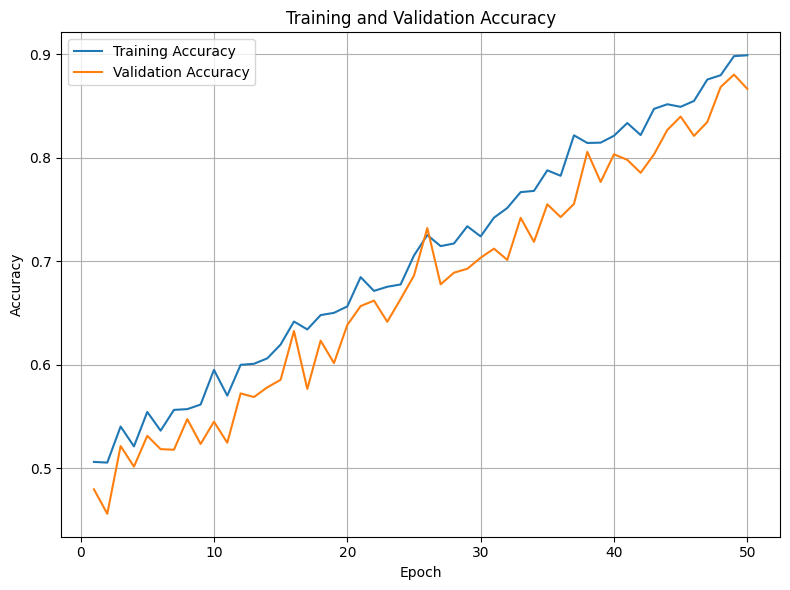

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_data_generator = ImageDataGenerator(rescale=1./255)
test_data_loader = test_data_generator.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized'],
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_data_loader)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 624 images belonging to 3 classes.
20/20 [==============================] - 124s 6s/step - loss: 0.6895 - accuracy: 0.8045
Test Loss: 0.6894882917404175
Test Accuracy: 0.8044871687889099


In [ ]:
preds = model.predict(test_data_generator)
pred_classes = np.argmax(preds, axis=1)

classes_true = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

precision_test = precision_score(classes_true, pred_classes, average='weighted')
recall_test = recall_score(classes_true, pred_classes, average='weighted')
f1_test = f1_score(classes_true, pred_classes, average='weighted')

print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)



# Tb data processing


In [ ]:
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras import layers, models

# directories for Tuberculosis and Normal images
tb_directory = '/content/drive/MyDrive/TB_Chest_Radiography_Database/Tuberculosis'
normal_directory = '/content/drive/MyDrive/TB_Chest_Radiography_Database/Normal'

# directory for the resampled dataset
resample_base_directory = '/content/drive/MyDrive/tuber2'
os.makedirs(resample_base_directory, exist_ok=True)

# subdirectories for Tuberculosis and resampled Normal images
resampled_tb_directory = os.path.join(resample_base_directory, 'Tuberculosis')
resampled_normal_directory = os.path.join(resample_base_directory, 'Normal_RS')
os.makedirs(resampled_tb_directory, exist_ok=True)
os.makedirs(resampled_normal_directory, exist_ok=True)

# Copyying all Tuberculosis images into the new directory
for file_name in os.listdir(tb_directory):
    shutil.copy(os.path.join(tb_directory, file_name), resampled_tb_directory)

# Randomly sampling 700 Normal images
normal_images_list = [os.path.join(normal_directory, file) for file in os.listdir(normal_directory)]
resampled_normal_images = resample(normal_images_list, replace=False, n_samples=700, random_state=42)

# Copy the resampled Normal images to the new directory
for file_path in resampled_normal_images:
    shutil.copy(file_path, resampled_normal_directory)


In [ ]:
# Directories for storing resampled and normalized datasets
resampled_tb_directory = '/content/drive/MyDrive/tuber2/Tuberculosis'
resampled_normal_directory = '/content/drive/MyDrive/tuber2/Normal_RS'
normalized_normal_directory = '/content/drive/MyDrive/tuber2/Normal_Norm'
normalized_tb_directory = '/content/drive/MyDrive/tuber2/Tuberculosis_Norm'

In [ ]:
def get_image_count(folder_path):
    valid_extensions = ['.jpg', '.jpeg', '.png']
    total_images = 0

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(extension) for extension in valid_extensions):
            total_images += 1
    return total_images

target_directory = '/content/drive/MyDrive/tuber2/Normal_RS'

print(f"Total images in the folder: {get_image_count(target_directory)}")


Total images in the folder: 700


In [ ]:
def process_images(directory, target_size=(224, 224), output_directory=None):
    if output_directory is None:
        output_directory = directory
    else:
        os.makedirs(output_directory, exist_ok=True)

    resized_count = 0
    already_resized_count = 0

    for file in os.listdir(directory):
        if file.endswith('.png'):
            input_path = os.path.join(directory, file)
            output_path = os.path.join(output_directory, file)

            with Image.open(input_path) as img:
                if img.size != target_size:
                    adjusted_image = img.resize(target_size)
                    adjusted_image.save(output_path)
                    resized_count += 1

                    scaled_image = np.array(adjusted_image) / 255.0
                    scaled_image = Image.fromarray((scaled_image * 255).astype(np.uint8))
                    scaled_image.save(output_path)
                else:
                    already_resized_count += 1
                    scaled_image = np.array(img) / 255.0
                    scaled_image = Image.fromarray((scaled_image * 255).astype(np.uint8))
                    scaled_image.save(output_path)

    print("Number of images resized:", resized_count)
    print("Number of images already resized:", already_resized_count)

target_size = (224, 224)
process_images(resampled_normal_directory, target_size, normalized_normal_directory)
process_images(resampled_tb_directory, target_size, normalized_tb_directory)

Number of images resized: 700
Number of images already resized: 0
Number of images resized: 700
Number of images already resized: 0


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Define source directories
normalized_normal_dir = '/content/drive/MyDrive/tuber2/Normal_Norm'
normalized_tb_dir = '/content/drive/MyDrive/tuber2/Tuberculosis_Norm'

# Define target directories for Normal and TB images
normal_train_dir = os.path.join(normalized_normal_dir, 'train')
normal_val_dir = os.path.join(normalized_normal_dir, 'val')
normal_test_dir = os.path.join(normalized_normal_dir, 'test')

tb_train_dir = os.path.join(normalized_tb_dir, 'train')
tb_val_dir = os.path.join(normalized_tb_dir, 'val')
tb_test_dir = os.path.join(normalized_tb_dir, 'test')

# Create the target directories
os.makedirs(normal_train_dir, exist_ok=True)
os.makedirs(normal_val_dir, exist_ok=True)
os.makedirs(normal_test_dir, exist_ok=True)
os.makedirs(tb_train_dir, exist_ok=True)
os.makedirs(tb_val_dir, exist_ok=True)
os.makedirs(tb_test_dir, exist_ok=True)

# Function to split and copy data into train, validation, and test sets
def distribute_data(source_directory, train_directory, val_directory, test_directory, test_split=0.15, val_split=0.1765):
    all_files = [os.path.join(source_directory, file) for file in os.listdir(source_directory) if os.path.isfile(os.path.join(source_directory, file))]
    train_val_files, test_files = train_test_split(all_files, test_size=test_split, random_state=42)
    train_files, val_files = train_test_split(train_val_files, test_size=val_split, random_state=42)

    def copy_to_target(files_list, target_directory):
        for file in files_list:
            shutil.copy(file, target_directory)

    copy_to_target(train_files, train_directory)
    copy_to_target(val_files, val_directory)
    copy_to_target(test_files, test_directory)

    print(f"Data split for {source_directory}: {len(test_files)} for testing, {len(val_files)} for validation, {len(train_files)} for training ")

# Perform the data splitting for both Normal and Tuberculosis datasets
distribute_data(normalized_normal_dir, normal_train_dir, normal_val_dir, normal_test_dir)
distribute_data(normalized_tb_dir, tb_train_dir, tb_val_dir, tb_test_dir)


Data split for /content/drive/MyDrive/tuber2/Normal_Norm: 105 for testing, 106 for validation, 489 for training 
Data split for /content/drive/MyDrive/tuber2/Tuberculosis_Norm: 105 for testing, 106 for validation, 489 for training 


# Defining Model Architectures for Tuberculosis datasets

CNN model built from scratch for Tuberculosis Dataset

In [ ]:
training_data_generator = ImageDataGenerator(rescale=1.0 / 255)
validation_data_generator = ImageDataGenerator(rescale=1.0 / 255)

# Setting up the data generators for training and validation datasets
train_data = training_data_generator.flow_from_directory(
    directory='/content/drive/MyDrive/tuber2/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

validation_data = validation_data_generator.flow_from_directory(
    directory='/content/drive/MyDrive/tuber2/val',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Building the convolutional neural network (CNN) model
cnn_model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(rate=0.5),
    layers.Dense(units=2, activation='softmax')
])

# Compiling the CNN model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Setting up callbacks for learning rate adjustment and early stopping
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.0001
)

early_stop_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# Training the model
training_history = cnn_model.fit(
    train_data,
    epochs=50,
    validation_data=validation_data,
    callbacks=[early_stop_callback, learning_rate_reduction]
)

# Saving the trained model
cnn_model.save('/content/drive/MyDrive/tuber2/CNN_tuber2.h5')

Found 978 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Epoch 1/50
16/16 [==============================] - 13s 640ms/step - loss: 0.6474 - accuracy: 0.6022 - val_loss: 0.4905 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 8s 500ms/step - loss: 0.4036 - accuracy: 0.7935 - val_loss: 0.2808 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 7s 448ms/step - loss: 0.3437 - accuracy: 0.8425 - val_loss: 0.2740 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 8s 489ms/step - loss: 0.2920 - accuracy: 0.8753 - val_loss: 0.2441 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 7s 467ms/step - loss: 0.2417 - accuracy: 0.9090 - val_loss: 0.2263 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 8s 476ms/step - loss: 0.2004 - accuracy: 0.9202 - val_loss: 0.1995 - val_accuracy: 0.9245 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
trained_model = load_model('/content/drive/MyDrive/tuber2/CNN_tuber2.h5')

test_data_generator = ImageDataGenerator(rescale=1.0 / 255)

test_data = test_data_generator.flow_from_directory(
    directory='/content/drive/MyDrive/tuber2/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

loss_on_test, accuracy_on_test = trained_model.evaluate(test_data)

print("Test Loss:", loss_on_test)
print("Test Accuracy:", accuracy_on_test)

Found 210 images belonging to 2 classes.
7/7 [==============================] - 1s 146ms/step - loss: 0.1723 - accuracy: 0.9333
Test Loss: 0.1723269671201706
Test Accuracy: 0.9333333373069763


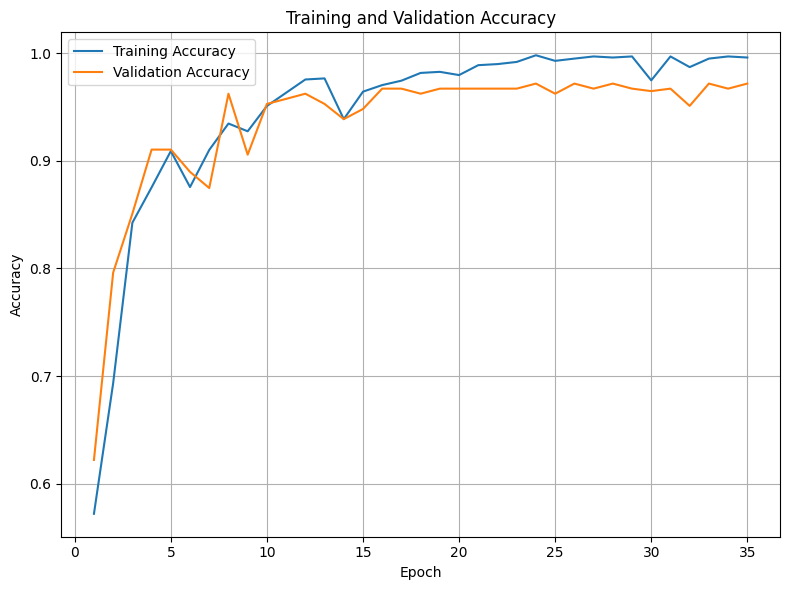

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predicted_probabilities = model.predict(test_data)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_data.classes
label_names = list(test_data.class_indices.keys())  # Retrieve class labels directly from the data generator

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1_score_value = f1_score(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score_value)

7/7 [==============================] - 1s 152ms/step
Precision: 0.9857583454281568
Recall: 0.9857142857142858
F1 Score: 0.9857139617678404


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.95      0.98      0.97       105
       Tuber       0.98      0.95      0.97       105

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



InceptionResNetV2 model for Tuberculosis Dataset

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_data = train_data_gen.flow_from_directory(
    '/content/drive/MyDrive/tuber2/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Validation data generator
validation_data = validation_data_gen.flow_from_directory(
    '/content/drive/MyDrive/tuber2/val',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained InceptionResNetV2 model
base_inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers to prevent training
for base_layer in base_inception_resnet.layers:
    base_layer.trainable = False

# Add custom classification layers
flatten_layer = layers.Flatten()(base_inception_resnet.output)
dropout_layer = layers.Dropout(0.5)(flatten_layer)
output_layer = layers.Dense(2, activation='softmax')(dropout_layer)
model = models.Model(inputs=base_inception_resnet.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
training_history = model.fit(
    train_data,
    epochs=50,
    validation_data=validation_data,
    callbacks=[early_stop, learning_rate_scheduler]
)

# Save the trained model
model.save('/content/drive/MyDrive/tuber2/InceptionResNetV2_tuber2.h5')

Found 210 images belonging to 2 classes.
4/4 [==============================] - 5s 354ms/step


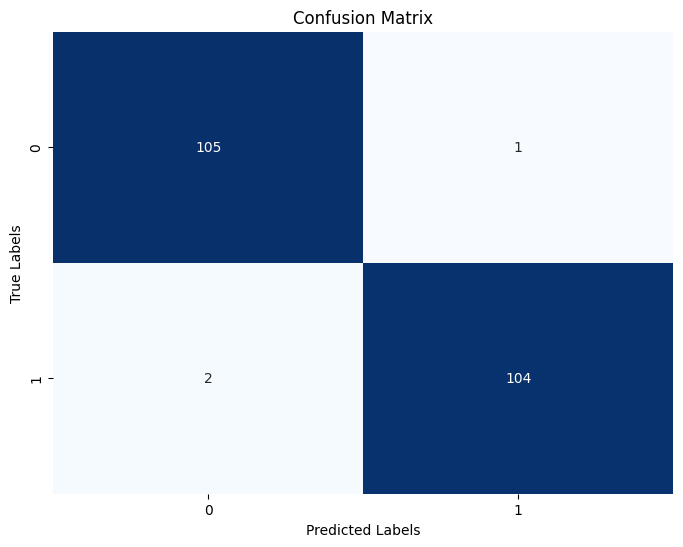

Test Loss: 0.08524250984191895
Test Accuracy: 0.976190447807312


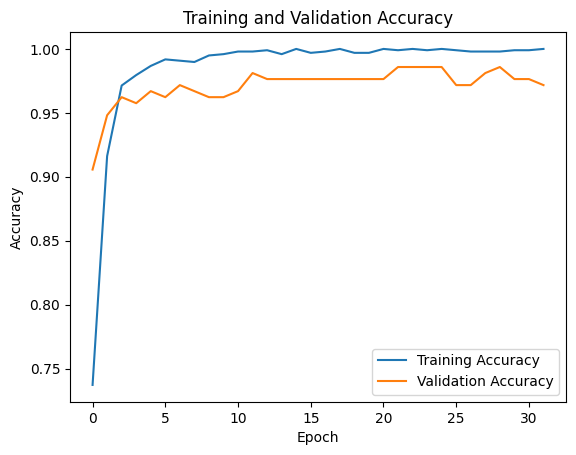

In [ ]:
cnn_model = load_model('/content/drive/MyDrive/tuber2/InceptionResNetV2_tuber2.h5')

# Prepare the test data generator
test_data_gen = ImageDataGenerator(rescale=1./255)
test_data = test_data_gen.flow_from_directory(
    '/content/drive/MyDrive/tuber2/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_data)

# Generate predictions and compute the confusion matrix
predicted_probabilities = cnn_model.predict(test_data)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
actual_labels = test_data.classes
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print test performance metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Generate predictions for the test dataset
predicted_probabilities = model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Get the true labels and class names
actual_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Calculate precision, recall, and F1 score
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1_score_value = f1_score(actual_labels, predicted_labels, average='weighted')

# Display the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score_value)

7/7 [==============================] - 4s 184ms/step
Precision: 0.981651376146789
Recall: 0.9809523809523809
F1 Score: 0.9809454677433989


#Combining both the datasets and training it with the VGG

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last 20 for fine-tuning
for layer in vgg_base.layers[:-20]:
    layer.trainable = False

# Build the complete model
model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Compile the model with a low learning rate
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the training data generator with augmentation
train_augmenter = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare the training data loader
train_loader = train_augmenter.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized', 'tuberculosis_Norm'],
    class_mode='categorical',
    subset='training'
)

# Define the validation data generator
validation_augmenter = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# Prepare the validation data loader
validation_loader = validation_augmenter.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized', 'tuberculosis_Norm'],
    class_mode='categorical',
    subset='validation'
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_loader,
    epochs=75,
    validation_data=validation_loader,
    callbacks=[early_stop],
    workers=4,
    use_multiprocessing=True,
    max_queue_size=10
)

model.save('/content/drive/MyDrive/chest_xray/Allclass.h5')

In [ ]:
# Define the test data generator with rescaling
test_data_generator = ImageDataGenerator(rescale=1.0 / 255)

# Load the test data using the generator
test_data_loader = test_data_generator.flow_from_directory(
    '/content/drive/MyDrive/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    classes=['NORMAL_normalized', 'BACTERIA_normalized', 'VIRUS_normalized', 'tuberculosis_Norm'],
    class_mode='categorical'
)

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_data_loader)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Found 764 images belonging to 4 classes.
24/24 [==============================] - 502s 21s/step - loss: 0.6524 - accuracy: 0.8887
Test Loss: 0.6524067521095276
Test Accuracy: 0.8887434601783752


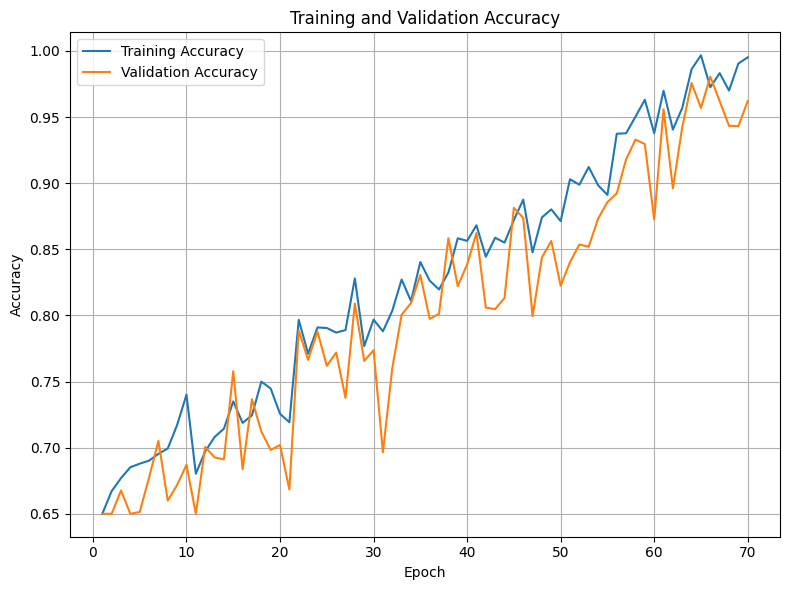

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Generate predictions for the test dataset
predictions = model.predict(test_data_loader)
predicted_labels = np.argmax(predictions, axis=1)

# Extract the true labels from the test dataset
actual_labels = test_data_loader.classes

# Calculate evaluation metrics
precision = precision_score(actual_labels, predicted_labels, average='macro')
recall = recall_score(actual_labels, predicted_labels, average='macro')
f1_score_value = f1_score(actual_labels, predicted_labels, average='macro')

# Print the evaluation metrics
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score_value}")

24/24 [==============================] - 4s 182ms/step
Test Precision: 0.8921803744876964
Test Recall: 0.8945710650256105
Test F1 Score: 0.8884411628483585


# **Test**

In [ ]:

base_path = '/content/drive/MyDrive/chest_xray/'

model_name ='model_custom.h5'
#model_name ='vggmodel.h5'
#model_name ='chexNet.h5'
#model_name ='CNN_From_Scratch_TB_Model.h5'
#model_name ='inception_tb.h5'
#model_name ='Allclass.h5'

model = load_model(base_path + model_name, compile=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
Prediction: Viral Pneumonia Detected


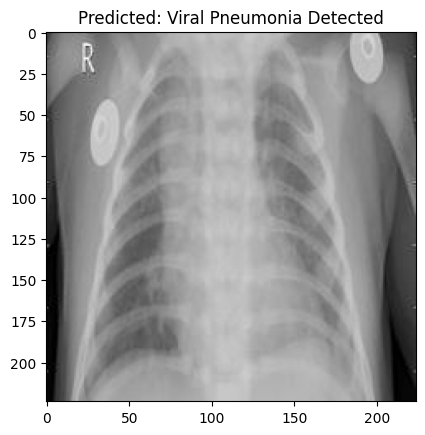

Normal - No signs of pneumonia: 0.01%
Bacterial Pneumonia Detected: 32.91%
Viral Pneumonia Detected: 67.09%

Final Prediction: Viral Pneumonia Detected


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array = img_array / 255.0

    return img_array

img_path = '/content/drive/MyDrive/chest_xray/test/BACTERIA_normalized/person78_bacteria_378.jpeg'

img_preprocessed = preprocess_image(img_path)

prediction = model.predict(img_preprocessed)

predicted_class = np.argmax(prediction, axis=1)

class_labels = {
    0: "Normal - No signs of pneumonia",
    1: "Bacterial Pneumonia Detected",
    2: "Viral Pneumonia Detected"
}

predicted_label = class_labels[predicted_class[0]]
print(f"Prediction: {predicted_label}")
predicted_label = class_labels[predicted_class[0]]

plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_label}")
plt.show()

probabilities = prediction[0]

for i, class_name in class_labels.items():
    print(f"{class_name}: {probabilities[i]*100:.2f}%")

predicted_label = class_labels[predicted_class[0]]
print(f"\nFinal Prediction: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Prediction: Tuberculosis Detected


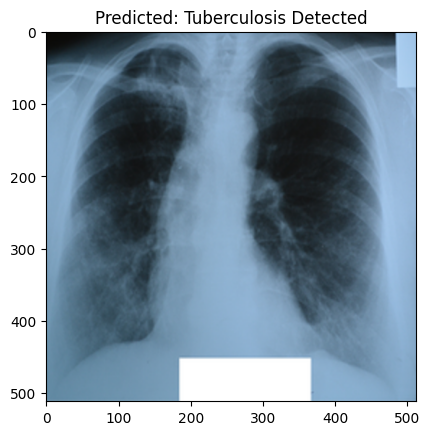

Normal - No signs of Tuberculosis: 0.00%
Tuberculosis Detected: 100.00%

Final Prediction: Tuberculosis Detected


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array = img_array / 255.0

    return img_array

img_path = '/content/drive/MyDrive/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-1.png'

img_preprocessed = preprocess_image(img_path)

prediction = model.predict(img_preprocessed)

predicted_class = np.argmax(prediction, axis=1)

class_labels = {
    0: "Normal - No signs of Tuberculosis",
    1: "Tuberculosis Detected",
}

predicted_label = class_labels[predicted_class[0]]
print(f"Prediction: {predicted_label}")
predicted_label = class_labels[predicted_class[0]]

plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_label}")
plt.show()

probabilities = prediction[0]

for i, class_name in class_labels.items():
    print(f"{class_name}: {probabilities[i]*100:.2f}%")

predicted_label = class_labels[predicted_class[0]]
print(f"\nFinal Prediction: {predicted_label}")